## Librerías

In [294]:
!pip install shap

In [295]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb
from scipy.stats import shapiro




from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from time import time
import duckdb
# %load_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:
import time
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import plotly.express as px
import shap
import os

import kaggle 
import glob



In [296]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [297]:
semillas =[ 400009,  500009,  600011,  700021,  800021]

In [298]:

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106


# Experimento

In [299]:
df_train = pd.read_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\Git\dmeyf2024\datasets\competencia_01.csv")

In [300]:
df_train.shape

(981946, 155)

In [301]:
mes_train = 202102
mes_test = 202104

In [302]:
df_train['clase_peso'] = 1.0
df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [303]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [304]:
df_train['clase_ternaria'].value_counts()

clase_ternaria
CONTINUA    645039
BAJA+1      169504
BAJA+2      167403
Name: count, dtype: int64

In [305]:
df_train['clase_binaria'] = np.where(df_train['clase_ternaria']=='CONTINUA', 0, 1)

In [306]:
df_train['foto_mes'].value_counts()

foto_mes
202106    164876
202105    164623
202104    164090
202103    163685
202102    162646
202101    162026
Name: count, dtype: int64

In [307]:
data = df_train
df_train = data[data['foto_mes']==mes_train]
df_test = data[data['foto_mes']==mes_test]


In [308]:
clase_peso = df_train['clase_peso']
X_train = df_train.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_train =df_train['clase_binaria']
X_test = df_test.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_test =df_test['clase_binaria']

In [309]:
# def objective(trial):
#     num_leaves = trial.suggest_int('num_leaves', 8, 100)
#     learning_rate = trial.suggest_float('learning_rate', 0.00005, 0.3)  # mas bajo, más iteraciones necesita
#     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 2000)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)

#     params = {
#         'objective': 'binary',
#         'metric': 'custom', 
#         'boosting_type': 'gbdt',
#         'device': 'gpu',  # Usar la GPU
#         'gpu_platform_id': 0,  # (opcional) ID de la plataforma GPU
#         'gpu_device_id': 0,     # (opcional) ID del dispositivo GPU
#         'first_metric_only': True,
#         'boost_from_average': True,
#         'feature_pre_filter': False,
#         'max_bin': 31,
#         'device': 'gpu',
#         'num_leaves': num_leaves,
#         'learning_rate': learning_rate,
#         'min_data_in_leaf': min_data_in_leaf,
#         'feature_fraction': feature_fraction,
#         'bagging_fraction': bagging_fraction,
#         'seed': semillas[0],
#         'verbose': -1
#     }

#     train_data = lgb.Dataset(X_train,
#                              label=Y_train,  # elegir la clase
#                              weight=clase_peso)
                             
#     cv_results = lgb.cv(
#         params,
#         train_data,
#         num_boost_round=300,  # modificar, subir y subir... y descomentar la línea inferior
        
#         feval=lgb_gan_eval,
#         stratified=True,
#         nfold=5,
#         seed=semillas[0]
#     )

#     max_gan = max(cv_results['valid gan_eval-mean'])
#     best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

#     # Guardamos cual es la mejor iteración del modelo
#     trial.set_user_attr("best_iter", best_iter)

#     return max_gan * 5


# storage_name = r"sqlite:///C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\Optuna\rf_segmentacion1\optimization_tree.db"
# study_name = "experimento_trazas_data_2"



# study = optuna.create_study(
#     direction="maximize",
#     study_name=study_name,
#     storage=storage_name,
#     load_if_exists=True,
# )

# import optuna

# class EarlyStoppingByImprovement:
#     def __init__(self, patience: int):
#         """
#         Args:
#             patience (int): Número de pruebas consecutivas sin mejora antes de detener la optimización.
#         """
#         self.patience = patience
#         self.best_value = None
#         self.no_improvement_trials = 0

#     def __call__(self, study, trial):
#         current_best_value = study.best_trial.value

#         # Si la métrica mejora, reseteamos el contador
#         if self.best_value is None or current_best_value > self.best_value:
#             self.best_value = current_best_value
#             self.no_improvement_trials = 0
#         else:
#             # Si no hay mejora, incrementamos el contador
#             self.no_improvement_trials += 1

#         # Detener si no ha habido mejora en 'self.patience' pruebas consecutivas
#         if self.no_improvement_trials >= self.patience:
#             print(f"Early stopping: No hay mejora en {self.patience} pruebas consecutivas.")
#             study.stop()

# # Crear el callback con 100 pruebas consecutivas sin mejora
# early_stopping_callback = EarlyStoppingByImprovement(patience=300)

# # Crear el estudio
# study = optuna.create_study(
#     direction="maximize",
#     study_name=study_name,
#     storage=storage_name,
#     load_if_exists=True,
# )

# # Optimizar el estudio con el callback personalizado
# study.optimize(objective, n_trials=30000)


In [310]:
train_data = lgb.Dataset(X_train,
                            label=Y_train,  # elegir la clase
                            weight=clase_peso)
                            

In [311]:
study.best_params

{'num_leaves': 44,
 'learning_rate': 0.026491108238180315,
 'min_data_in_leaf': 1521,
 'feature_fraction': 0.4981060251618862,
 'bagging_fraction': 0.38125736379779296}

In [312]:
w_train = df_train.loc[X_train.index, 'clase_peso']

# best_iter = study.best_trial.user_attrs["best_iter"]
# print(f"Mejor cantidad de árboles para el mejor model {best_iter}")

# params = {
#     'objective': 'binary',
#     'boosting_type': 'gbdt',
#     'first_metric_only': True,
#     'boost_from_average': True,
#     'feature_pre_filter': False,
#     'max_bin': 31,
#     'num_leaves': study.best_params['num_leaves'],
#     'learning_rate': study.best_params['learning_rate'],
#     'min_data_in_leaf': study.best_params['min_data_in_leaf'],
#     'feature_fraction': study.best_params['feature_fraction'],
#     'bagging_fraction': study.best_params['bagging_fraction'],
#     'seed': semillas[0],
#     'verbose': 0
# }



# model = lgb.train(params,
#                   train_data,
#                   num_boost_round=best_iter)

In [313]:
#lgb default 
model_default = lgb.train({}, train_data)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18934
[LightGBM] [Info] Number of data points in the train set: 162646, number of used features: 147
[LightGBM] [Info] Start training from score 0.011110


### Prediccion

In [314]:
df_test.shape

(164090, 157)

In [315]:
w_data_test = df_test.loc[X_test.index, 'clase_peso']
test_data = lgb.Dataset(X_test, label= Y_test, weight=w_data_test)

In [316]:

# y_pred = model.predict(X_test)
y_pred_default = model_default.predict(X_test)


In [317]:
# lgb_gan_eval(y_pred, test_data)

In [318]:
lgb_gan_eval(y_pred_default, test_data)

('gan_eval', 140378000, True)

In [319]:
explainer = shap.TreeExplainer(model_default)
shap_values = explainer.shap_values(X_train)

In [320]:
shap_df = pd.DataFrame(shap_values, columns = X_train.columns)


In [321]:
importancia_shap = pd.DataFrame(np.abs(shap_values).mean(0), columns = ['valores_shap'])
importancia_shap['variables'] = X_train.columns
importancia_shap = importancia_shap.sort_values(by = 'valores_shap', ascending = False)

In [322]:
df_trazas_shap = importancia_shap[importancia_shap['valores_shap'] == 0]

In [323]:
lista = df_trazas_shap['variables'].to_list()



### Analisis de trazas

In [324]:
from scipy.stats import skew

# asimetria = skew(df['variable'])
valores_skew = []
for variable in lista:
    asimetria = skew(X_train[variable])
    valores_skew.append(asimetria)  
df_trazas_shap['skew'] = valores_skew


C:\Users\Admin\AppData\Local\Temp\ipykernel_26592\2864500309.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  asimetria = skew(X_train[variable])
C:\Users\Admin\AppData\Local\Temp\ipykernel_26592\2864500309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['skew'] = valores_skew


In [325]:
df_trazas_shap

,valores_shap,variables,skew
15,0.0,mcuenta_corriente_adicional,199.845594
152,0.0,Visa_cadelantosefectivo,NaN
150,0.0,Visa_mconsumototal,NaN
130,0.0,Master_cadelantosefectivo,NaN
3,0.0,cliente_vip,19.126278
144,0.0,Visa_madelantodolares,NaN
143,0.0,Visa_madelantopesos,NaN
132,0.0,Visa_delinquency,NaN
117,0.0,Master_msaldodolares,NaN
122,0.0,Master_madelantodolares,NaN


In [326]:
stat_shapiro=[]
p_value_shapiro=[]
normalidad=[]

for variable in lista:
    shapiro_normal = False
    stat, p = shapiro(X_train[variable])
    if p < 0.05 and stat < 0.70:
        
        shapiro_normal = False
        normalidad.append(shapiro_normal)
        stat_shapiro.append(stat)
        p_value_shapiro.append(p)
        print(f'Variable {variable} se rechaza la hipótesis nula: distribución no normal.')
    else:
        shapiro_normal = True
        stat_shapiro.append(stat)
        p_value_shapiro.append(p)
        normalidad.append(shapiro_normal)
        print('No se rechaza la hipótesis nula: distribución normal.')
        
df_trazas_shap['shapiro_normal'] = normalidad
df_trazas_shap['stat_shapiro'] = stat_shapiro
df_trazas_shap['p_value_shapiro'] = p_value_shapiro

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 162646.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Variable mcuenta_corriente_adicional se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variable cliente_vip se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variable ccuenta_corriente se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variable minversion1_dolares se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipót

C:\Users\Admin\AppData\Local\Temp\ipykernel_26592\4159320167.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['shapiro_normal'] = normalidad
C:\Users\Admin\AppData\Local\Temp\ipykernel_26592\4159320167.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['stat_shapiro'] = stat_shapiro
C:\Users\Admin\AppData\Local\Temp\ipykernel_26592\4159320167.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [327]:
df_trazas_shap

,valores_shap,variables,skew,shapiro_normal,stat_shapiro,p_value_shapiro
15,0.0,mcuenta_corriente_adicional,199.845594,False,0.000831,3.275188e-198
152,0.0,Visa_cadelantosefectivo,NaN,True,NaN,NaN
150,0.0,Visa_mconsumototal,NaN,True,NaN,NaN
130,0.0,Master_cadelantosefectivo,NaN,True,NaN,NaN
3,0.0,cliente_vip,19.126278,False,0.025792,2.782799e-197
144,0.0,Visa_madelantodolares,NaN,True,NaN,NaN
143,0.0,Visa_madelantopesos,NaN,True,NaN,NaN
132,0.0,Visa_delinquency,NaN,True,NaN,NaN
117,0.0,Master_msaldodolares,NaN,True,NaN,NaN
122,0.0,Master_madelantodolares,NaN,True,NaN,NaN


In [328]:
variables_no_normales = []
for idx, variable in df_trazas_shap.iterrows():
    if variable['shapiro_normal'] == False and variable['skew'] != 0:
        variable_anormal = variable['variables']
        variables_no_normales.append(variable_anormal)



In [329]:
variables_no_normales

['mcuenta_corriente_adicional',
 'cliente_vip',
 'ccuenta_corriente',
 'minversion1_dolares',
 'ccuenta_debitos_automaticos',
 'cpagomiscuentas',
 'cpagodeservicios',
 'cplazo_fijo',
 'cpayroll2_trx',
 'catm_trx_other',
 'mpayroll2',
 'mplazo_fijo_pesos',
 'cinversion1',
 'minversion1_pesos',
 'cseguro_vivienda',
 'cseguro_auto',
 'cseguro_vida',
 'mprestamos_hipotecarios',
 'cprestamos_hipotecarios',
 'catm_trx',
 'ccajas_extracciones',
 'cinversion2',
 'cprestamos_prendarios',
 'mcheques_emitidos_rechazados',
 'ccheques_emitidos_rechazados',
 'mcheques_depositados_rechazados',
 'ccheques_depositados_rechazados',
 'ccheques_emitidos',
 'mcheques_depositados',
 'ccheques_depositados',
 'cextraccion_autoservicio',
 'cforex_buy',
 'cforex',
 'mforex_buy']

<Axes: xlabel='cforex', ylabel='Count'>

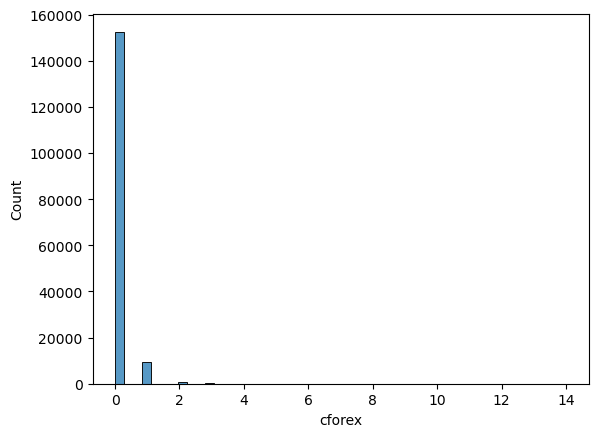

In [330]:
sns.histplot(X_train['cforex'], bins=50)

In [331]:
from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import PowerTransformer

for variable in variables_no_normales:

    pt = PowerTransformer(method='yeo-johnson')
    X_train[variable] = pt.fit_transform(X_train[[variable]]+1)
    
    X_test[variable] = pt.transform(X_test[[variable]]+1)

<Axes: xlabel='cforex', ylabel='Count'>

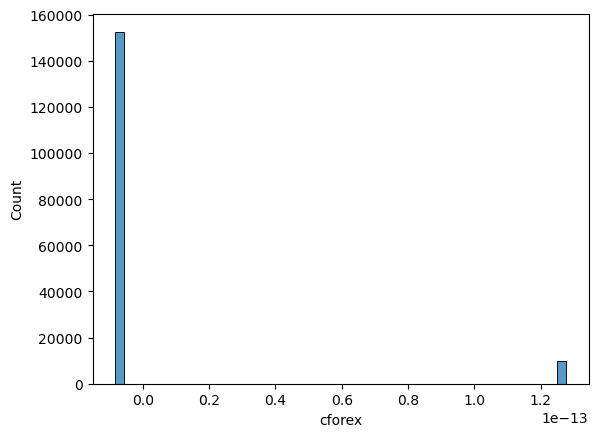

In [332]:
sns.histplot(X_train['cforex'], bins=50)

In [210]:

train_data_post = lgb.Dataset(X_train,
                          label= Y_train,
                          weight=w_train)

model_default_post = lgb.train({}, train_data_post)


test_data_post = lgb.Dataset(X_test,
                          label= Y_test,
                          weight=w_data_test)

y_pred_default_post = model_default_post.predict(X_test)



lgb_gan_eval(y_pred_default_post, test_data_post)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17668
[LightGBM] [Info] Number of data points in the train set: 162646, number of used features: 147
[LightGBM] [Info] Start training from score 0.011110


('gan_eval', 141071000, True)

In [211]:
explainer_post = shap.TreeExplainer(model_default_post)
shap_values_post = explainer_post.shap_values(X_train)

In [212]:
shap_df_post = pd.DataFrame(shap_values_post, columns = X_train.columns)


In [213]:
importancia_shap_post = pd.DataFrame(np.abs(shap_values_post).mean(0), columns = ['valores_shap'])
importancia_shap_post['variables'] = X_train.columns
importancia_shap_post = importancia_shap_post.sort_values(by = 'valores_shap', ascending = False)

In [214]:
df_trazas_shap_post = importancia_shap_post[importancia_shap_post['valores_shap'] == 0]

In [215]:
lista_post = df_trazas_shap_post['variables'].to_list()
lista_post



['cliente_vip',
 'Visa_madelantopesos',
 'Visa_madelantodolares',
 'Visa_mconsumototal',
 'Visa_cadelantosefectivo',
 'Master_mconsumototal',
 'Master_mpagosdolares',
 'mcuenta_corriente_adicional',
 'Visa_delinquency',
 'Master_madelantopesos',
 'Master_cadelantosefectivo',
 'Master_madelantodolares',
 'Master_msaldodolares',
 'ccuenta_corriente',
 'cinversion2',
 'Master_delinquency',
 'catm_trx_other',
 'ctarjeta_visa_descuentos',
 'mcajeros_propios_descuentos',
 'ccajeros_propios_descuentos',
 'cpagomiscuentas',
 'cpagodeservicios',
 'mplazo_fijo_pesos',
 'ccuenta_debitos_automaticos',
 'cpayroll2_trx',
 'mpayroll2',
 'cinversion1',
 'minversion1_pesos',
 'minversion1_dolares',
 'cseguro_vivienda',
 'cseguro_auto',
 'cseguro_vida',
 'mtarjeta_visa_descuentos',
 'ctarjeta_master_descuentos',
 'mtarjeta_master_descuentos',
 'ccheques_emitidos',
 'ccajas_extracciones',
 'cprestamos_prendarios',
 'mcheques_emitidos_rechazados',
 'ccheques_emitidos_rechazados',
 'mcheques_depositados_re

In [216]:
len(lista)

54

In [217]:
len(lista_post)

51

In [ ]:
for x in lista:
    if x in lista_post:
        print(f'La variable {x} se encuentra en ambas listas')
    else:
        print(f'--------La variable {x} no se encuentra en ambas listas')
for x in lista_post:
    if x not in lista:
        print (f'!!!!!!!! La variable {x} no se encuentra en ambas listas y es nueva')

La variable mcuenta_corriente_adicional se encuentra en ambas listas
La variable Visa_cadelantosefectivo se encuentra en ambas listas
La variable Visa_mconsumototal se encuentra en ambas listas
La variable Master_cadelantosefectivo se encuentra en ambas listas
La variable cliente_vip se encuentra en ambas listas
La variable Visa_madelantodolares se encuentra en ambas listas
La variable Visa_madelantopesos se encuentra en ambas listas
La variable Visa_delinquency se encuentra en ambas listas
La variable Master_msaldodolares se encuentra en ambas listas
La variable Master_madelantodolares se encuentra en ambas listas
La variable ccuenta_corriente se encuentra en ambas listas
La variable Master_mconsumototal se encuentra en ambas listas
La variable Master_madelantopesos se encuentra en ambas listas
--------La variable Visa_Finiciomora no se encuentra en ambas listas
La variable Master_mpagosdolares se encuentra en ambas listas
La variable minversion1_dolares se encuentra en ambas listas
L